In [1]:
from mu2e import mu2e_ext_path
from mu2e.dataframeprod import DataFrameMaker
from mu2e.mu2eplots import mu2e_plot, mu2e_plot3d
from mu2e.src.fiteval_c2 import FitFunctionMaker2

ffm = FitFunctionMaker2('../mu2e/src/Mau10_800mm_long.csv')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,8)
matplotlib.rcParams['contour.negative_linestyle'] = 'solid'

/usr/local/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning:

The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.

/usr/local/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning:

IPython.utils.traitlets has moved to a top-level traitlets package.



<IPython.core.display.Javascript object>

# Relative Field Monitoring for Detector Train

Measuring and monitoring the position of the magnetic field and the detector equipment in the DS is, obviously, important.  When the DS is open, physically measuring the position and configuration of these objects has been planned out in detail.  Once the DS closes and is under vacuum, the detector may shift slightly.  This shift could have a severe impact on the accuracy of the experiment if it is left unknown.

Instead of physically measuring the position of the detector train, and inferring their relation to the magnetic field, we can make a few assumptions, and simplify our problem greatly.

Assumptions:
 1. The detector train is a semi-rigid body.  It can be viewed as a parallelepiped, where the angles between the planes can vary due to movement at the vertices.  The edges cannot be compressed, lengthened, or warped in any way.
 2. The magnetic field is static.  In principle, this constraint can be relaxed, as long as there is a frame of reference where the field is static and the detector train moves in the manner mentioned above.  It is possible that this constraint could be relaxed even further, to allow for linear expansion or compression of the field.
 3. There exist a sufficient number of hall probes located on the detector train, which can be measured with high precision before and after the DS is sealed.
    
Using these detector train hall probes, we should be able to determine the relative position of the detector train in the magnetic field, without measuring the absolute position of the train via some sort of laser alignment system.

### Detector Train Layout
![detector train layout](Mu2E_Extras/plots/detector_train.png)

### Detector Train Cross-Section
![detector train xs](Mu2E_Extras/plots/detector_train_xs.png)

In [2]:
df = DataFrameMaker(mu2e_ext_path+'datafiles/Mau10/Standard_Maps/Mu2e_DSMap',use_pickle = True).data_frame

In [150]:
mu2e_plot3d(df, 'X', 'Z', 'Bz', '-800<=X<=800 and Y==0 and 4200<Z<15000',
            info = 'Mau10', df_fit=False, mode='plotly_nb', ptype='3d')

In [149]:
mu2e_plot3d(df, 'X', 'Z', 'Br', '-800<=X<=800 and Y==0 and 4200<Z<15000',
            info = 'Mau10', df_fit=False, mode='plotly_nb', ptype='3d')

## Testing Injectivity for 2D case (visual)

In [18]:
nominal = ffm.mag_field_function(900,0,5000,True)
print 'Bx\tBy\tBz'
print nominal[0],nominal[1],nominal[2]
def bz_func(x,y,z):
    return ffm.mag_field_function(x,y,z,True)[2]
vbz_func = np.vectorize(bz_func,excluded=['y'])
 
def by_func(x,y,z):
    return ffm.mag_field_function(x,y,z,True)[1]
vby_func = np.vectorize(by_func,excluded=['y'])
 
def bx_func(x,y,z):
    return ffm.mag_field_function(x,y,z,True)[0]
vbx_func = np.vectorize(bx_func,excluded=['y'])

Bx	By	Bz
-0.109793743494 -3.82189953452e-08 1.44305374259


Let us look at how these values vary as we move the probe by up to 1 cm in the x and z planes.

In [19]:
xs = np.linspace(890,910,201)
ys = np.linspace(-10,10,201)
zs = np.linspace(4990,5010,201)
xxs,zzs = np.meshgrid(xs,zs)
bxs = vbx_func(x=xxs, y=0, z=zzs)
bzs = vbz_func(x=xxs, y=0, z=zzs)

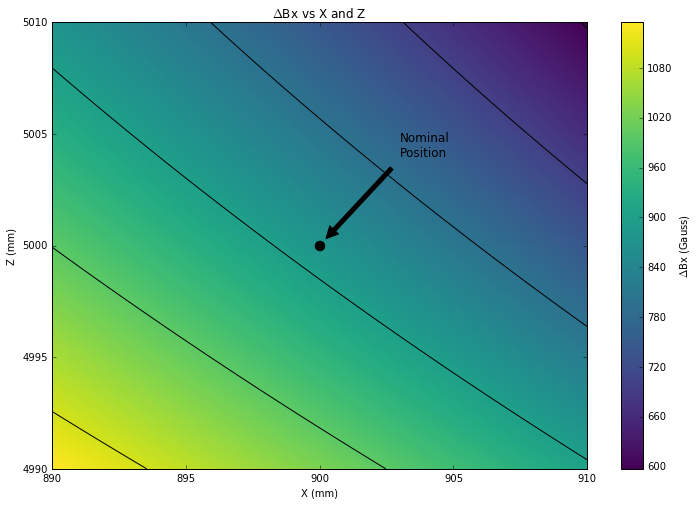

In [23]:
pcm = plt.pcolormesh(xxs,zzs,(bxs-nominal[0])*10000,cmap='viridis')
plt.contour(xxs, zzs, bxs, 6, colors='k', linewidth=2)
plt.title('$\Delta$Bx vs X and Z')
plt.xlabel('X (mm)')
plt.ylabel('Z (mm)')
cb = plt.colorbar(pcm)
cb.set_label('$\Delta$Bx (Gauss)')
plt.plot(900,5000,'o',markersize=10, color='k')
plt.annotate('Nominal\nPosition', xy=(900, 5000), xytext=(903, 5004),
            arrowprops=dict(facecolor='black', shrink=0.08),
            size='large',
            )

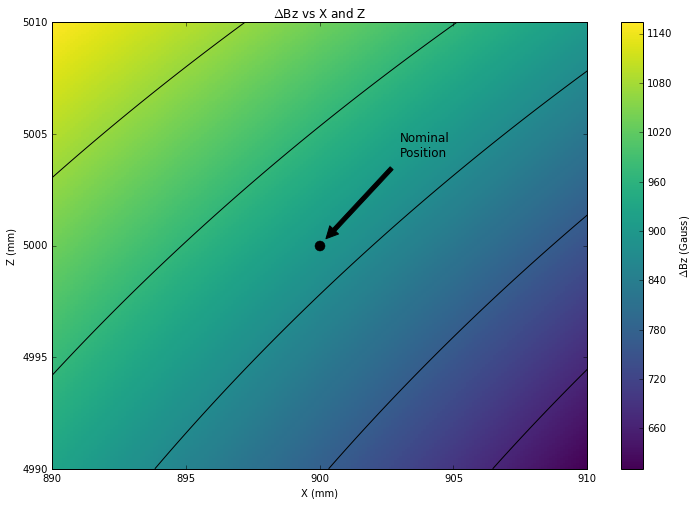

In [24]:
pcm = plt.pcolormesh(xxs,zzs,(bzs-nominal[2])*10000,cmap='viridis')
plt.contour(xxs, zzs, bzs, 6, colors='k', linewidth=2)
plt.title('$\Delta$Bz vs X and Z')
plt.xlabel('X (mm)')         
plt.ylabel('Z (mm)') 
cb = plt.colorbar(pcm)
cb.set_label('$\Delta$Bz (Gauss)')
plt.plot(900,5000,'o',markersize=10, color='k')
plt.annotate('Nominal\nPosition', xy=(900, 5000), xytext=(903, 5004),
            arrowprops=dict(facecolor='black', shrink=0.08),
            size='large',
            )


This seems to be indicating that the field is injective- that is, it is uniquely defined for all (x,y,z) coordinates.  However, we are only looking at 2 coordinates in a 2d plane.  We need to show that this field is sufficiently unique in 3D.  This is difficult graphically, but not so difficult if we use some set properties and some scaling.

## Testing Injectivity for 3D (set uniqueness)

In [191]:
def bz_func_full(x,y,z):
    return ffm.mag_field_function(x,y,z,True)[2]
vbz_func_full = np.vectorize(bz_func_full)
 
def by_func_full(x,y,z):
    return ffm.mag_field_function(x,y,z,True)[1]
vby_func_full = np.vectorize(by_func_full)
 
def bx_func_full(x,y,z):
    return ffm.mag_field_function(x,y,z,True)[0]
vbx_func_full = np.vectorize(bx_func_full)

In [241]:
xs_50 = np.linspace(797.5,802.5,11)
ys_50 = np.linspace(-2.5,2.5,11)
zs_50 = np.linspace(6768.5,6773.,11)
xxxs,yyys,zzzs = np.meshgrid(xs_50,ys_50,zs_50)
print 'xs'
bxs_50 = vbx_func_full(x=xxxs, y=yyys, z=zzzs)


xs


In [242]:
print 'ys'
bys_50 = vby_func_full(x=xxxs, y=yyys, z=zzzs)

ys


In [243]:
print 'zs'
bzs_50 = vbz_func_full(x=xxxs, y=yyys, z=zzzs)

zs


In [250]:
bxs_50_g = np.asarray(bxs_50.flatten()*10000,dtype=int)

In [251]:
bys_50_g = np.asarray(bys_50.flatten()*10000,dtype=int)

In [252]:
bzs_50_g = np.asarray(bzs_50.flatten()*10000,dtype=int)

In [253]:
bs_50_g = zip(bxs_50_g,bys_50_g,bzs_50_g)

In [254]:
len(bs_50_g)

1331

In [255]:
len(set(bs_50_g))

1331

In [228]:
print len(bs_50_g)==len(set(bs_50_g))

False


In [244]:
yyys

array([[[-2.5, -2.5, -2.5, -2.5, -2.5, -2.5],
        [-2.5, -2.5, -2.5, -2.5, -2.5, -2.5],
        [-2.5, -2.5, -2.5, -2.5, -2.5, -2.5],
        [-2.5, -2.5, -2.5, -2.5, -2.5, -2.5],
        [-2.5, -2.5, -2.5, -2.5, -2.5, -2.5],
        [-2.5, -2.5, -2.5, -2.5, -2.5, -2.5]],

       [[-1.5, -1.5, -1.5, -1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5, -1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5, -1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5, -1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5, -1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5, -1.5, -1.5, -1.5]],

       [[-0.5, -0.5, -0.5, -0.5, -0.5, -0.5],
        [-0.5, -0.5, -0.5, -0.5, -0.5, -0.5],
        [-0.5, -0.5, -0.5, -0.5, -0.5, -0.5],
        [-0.5, -0.5, -0.5, -0.5, -0.5, -0.5],
        [-0.5, -0.5, -0.5, -0.5, -0.5, -0.5],
        [-0.5, -0.5, -0.5, -0.5, -0.5, -0.5]],

       [[ 0.5,  0.5,  0.5,  0.5,  0.5,  0.5],
        [ 0.5,  0.5,  0.5,  0.5,  0.5,  0.5],
        [ 0.5,  0.5,  0.5,  0.5,  0.5,  0.5],
        [ 0.5,  0.5,  0.5,  

So what have we just shown? For a 10x10x10 mm box around our hall probe, with a granularity of 0.2mm, the field is uniquely defined for each point if we have measurement accuracy of at least 0.5 Gauss for each component.

# Finding Optimal Monitoring Placement

The sensitivity of the hall probe monitor is dependent on the strength of the gradient surrounding its nominal position.  The hall probe must also be located in a region that is valid for the field mapper, or there is no way to quantify the motion of the probe by measuring the field strength.

In [64]:
df_plane = df.query('Y==0 and R<=800 and 4200<Z<15000')

In [65]:
bz_plane = df_plane.pivot('X','Z','Bz')
br_plane = df_plane.pivot('X','Z','Br')

In [66]:
xi,zi = np.meshgrid(bz_plane.columns, bz_plane.index)

In [67]:
bz_plane.shape, xi.shape, zi.shape

((65, 432), (65, 432), (65, 432))

In [83]:
bz_plane_grad = np.gradient(bz_plane,25)
br_plane_grad = np.gradient(br_plane,25)

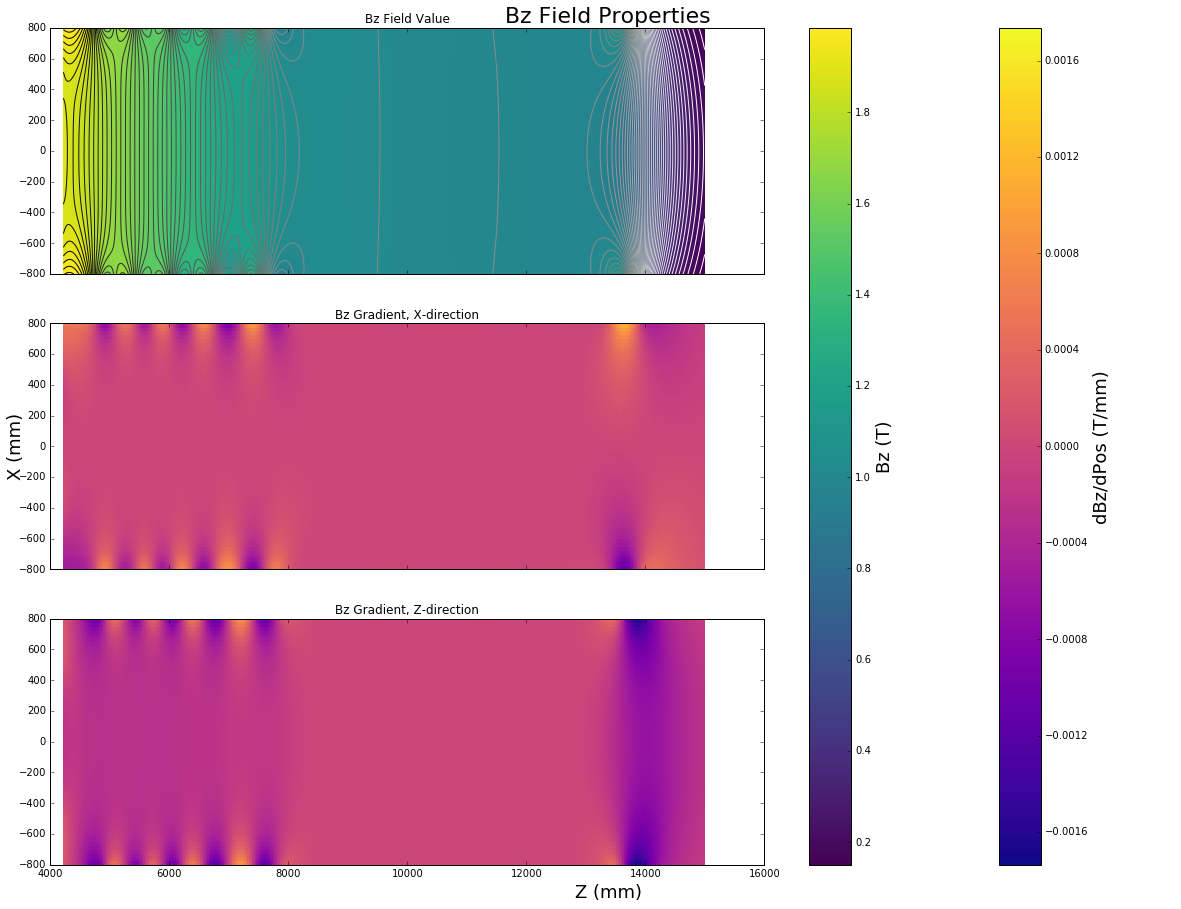

In [179]:
fig, ax = plt.subplots(3, sharex=True, sharey=True)
fig.set_size_inches(20,15)
pcb = ax[0].pcolormesh(xi,zi, bz_plane.values, cmap=plt.get_cmap('viridis'))
ax[0].set_title('Bz Field Value')
ax[0].contour(xi,zi,bz_plane.values, 100, cmap=plt.get_cmap('gray_r'))
grad_lim = np.max(np.abs(bz_plane_grad))
pc = ax[1].pcolormesh(xi,zi, bz_plane_grad[0], cmap=plt.get_cmap('plasma'), vmin=-grad_lim, vmax=grad_lim)
ax[1].set_title('Bz Gradient, X-direction')
ax[2].pcolormesh(xi,zi, bz_plane_grad[1], cmap=plt.get_cmap('plasma'), vmin=-grad_lim, vmax=grad_lim)
ax[2].set_title('Bz Gradient, Z-direction')
ax3 = fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.xlabel("Z (mm)", fontsize=18)
plt.ylabel("X (mm)", fontsize=18)
plt.title('Bz Field Properties', fontsize=22)
cb = fig.colorbar(pc, ax=ax.ravel().tolist())
cb.set_label('dBz/dPos (T/mm)', fontsize=18)
cb2 = fig.colorbar(pcb, ax=ax.ravel().tolist())
cb2.set_label('Bz (T)', fontsize=18)

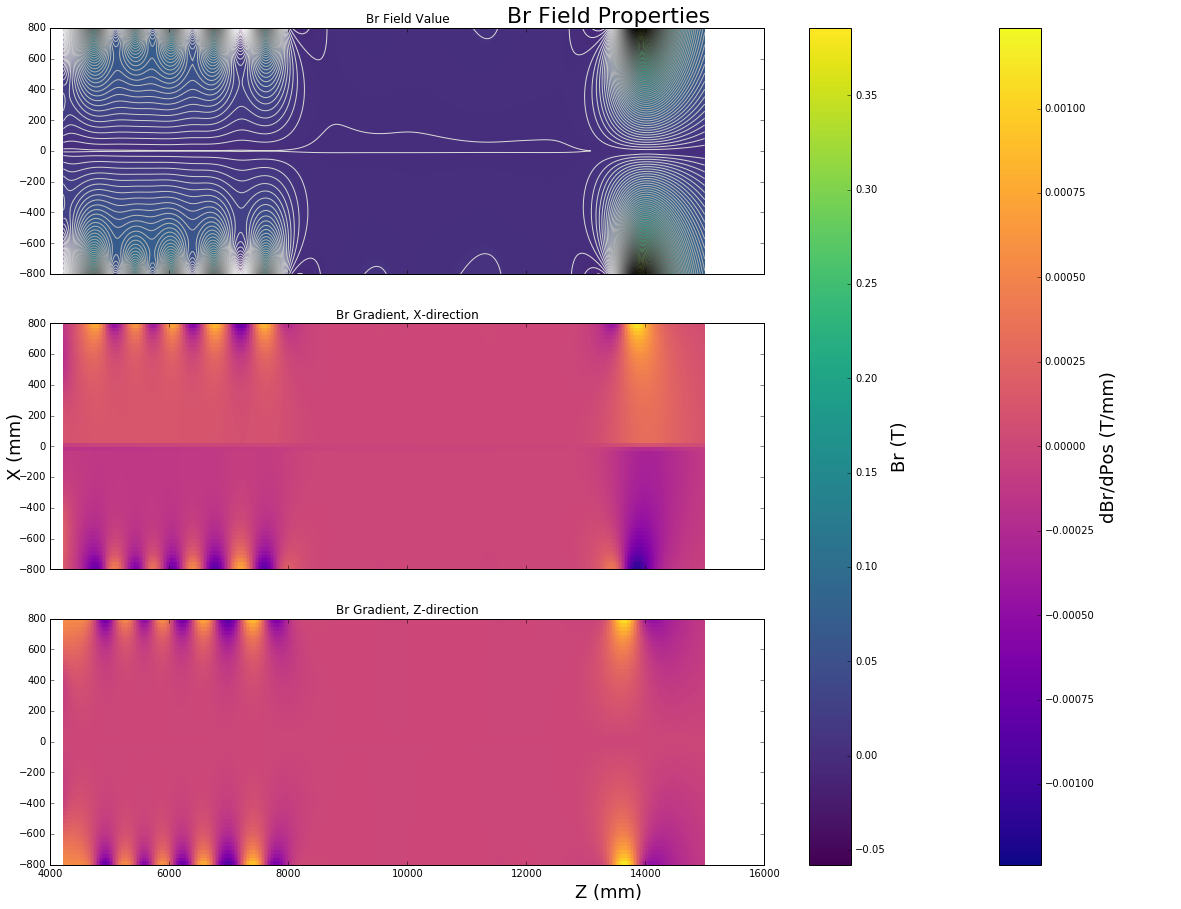

In [180]:
fig, ax = plt.subplots(3, sharex=True, sharey=True)
fig.set_size_inches(20,15)
pcb = ax[0].pcolormesh(xi,zi, br_plane.values, cmap=plt.get_cmap('viridis'))
ax[0].set_title('Br Field Value')
ax[0].contour(xi,zi,br_plane.values, 100, cmap=plt.get_cmap('gray_r'))
grad_lim = np.max(np.abs(br_plane_grad))
pc = ax[1].pcolormesh(xi,zi, br_plane_grad[0], cmap=plt.get_cmap('plasma'), vmin=-grad_lim, vmax=grad_lim)
ax[1].set_title('Br Gradient, X-direction')
ax[2].pcolormesh(xi,zi, br_plane_grad[1], cmap=plt.get_cmap('plasma'), vmin=-grad_lim, vmax=grad_lim)
ax[2].set_title('Br Gradient, Z-direction')
ax3 = fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.xlabel("Z (mm)", fontsize=18)
plt.ylabel("X (mm)", fontsize=18)
plt.title('Br Field Properties', fontsize=22)
cb = fig.colorbar(pc, ax=ax.ravel().tolist())
cb.set_label('dBr/dPos (T/mm)', fontsize=18)
cb2 = fig.colorbar(pcb, ax=ax.ravel().tolist())
cb2.set_label('Br (T)', fontsize=18)